In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import matplotlib as mpl
import os
from glob import glob

from _load_data import * # Getting our specific labels, formatting, and data
from _cd_diagram import *

# Getting some free samples
results_df.sample(1)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierTopDownOnlyLast.py', '../models/Vanilla.py', '../models/SimplifierTopDown1e-2.py', '../models/SimplifierTopDown1e-1.py', '../models/SimplifierBottomUp.py', '../models/SimplifierTopDown1e-10.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierTopDown1e-6.py', '../models/SimplifierTopDown1e-4.py', '../models/SimplifierTopDown.py', '../models/SimplifierTopDown1e-0.py'] ['Top Down (only last)', 'Without simplify', 'Top Down 1e-2', 'Top Down 1e-1', 'Bottom Up', 'Top Down 1e-10', 'Bottom Up (only last)', 'Top Down 1e-6', 'Top Down 1e-4', 'Top Down', 'Top Down 1e-0']
(899, 14)
['Top Down (only last)' 'Without simplify' 'Bottom Up'
 'Bottom Up (only last)' 'Top Down']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing' 'Yacht']
[5, 25, 45, 65, 85, 105, 125, 145, 165, 185, 205, 225, 245, 254]


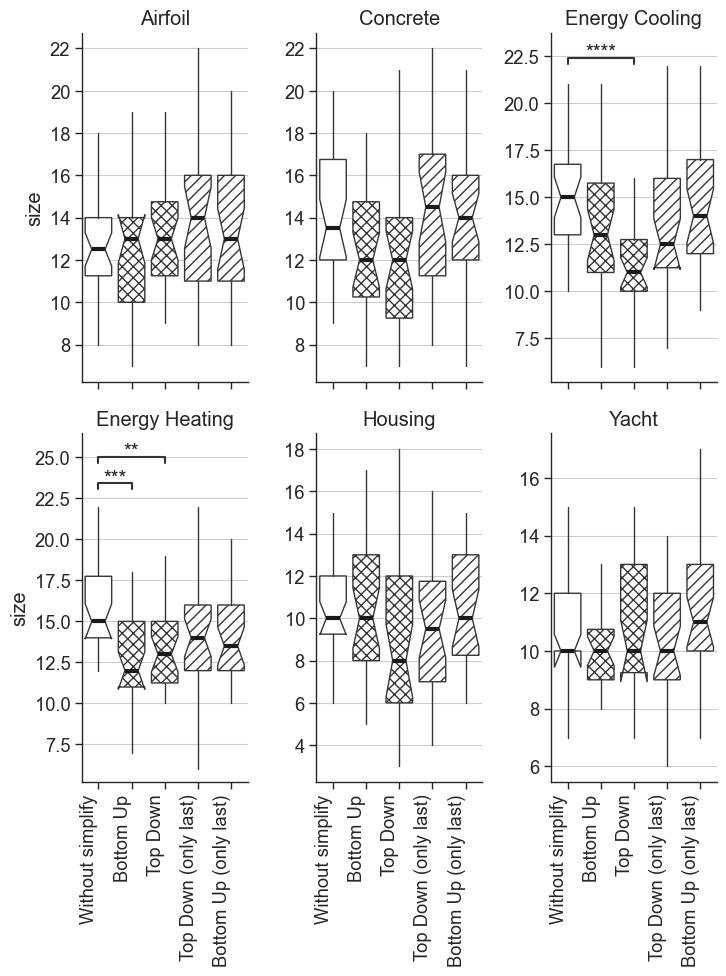

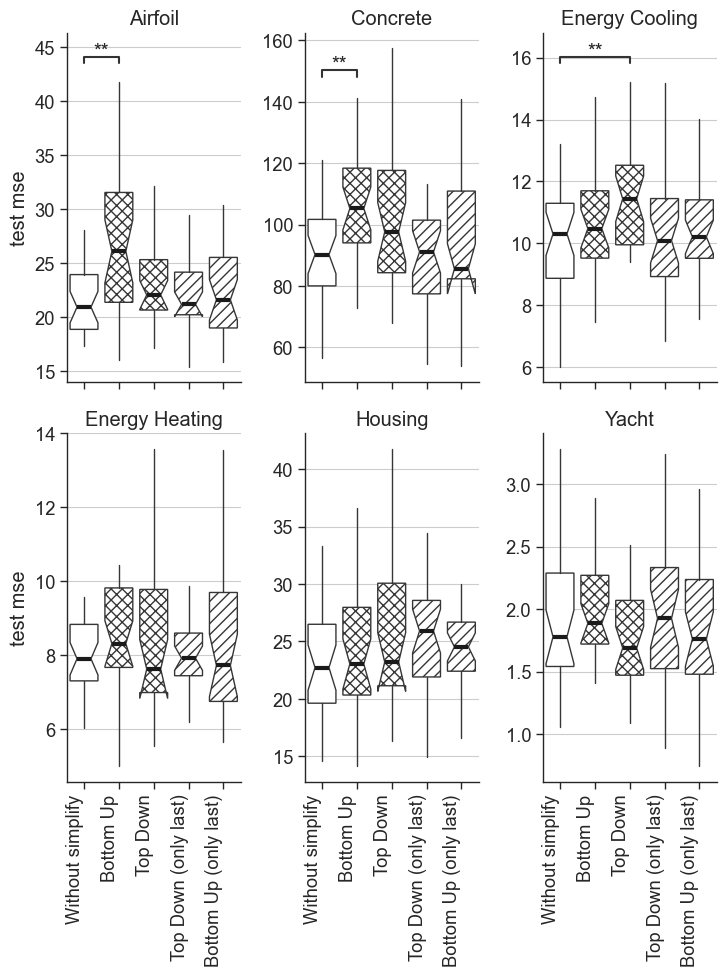

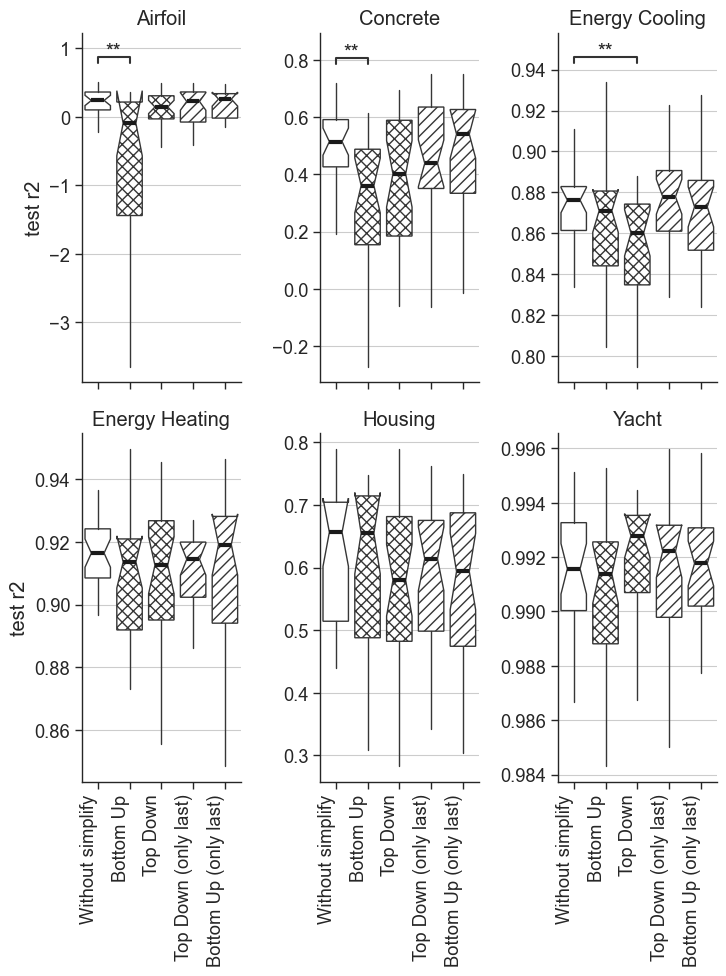

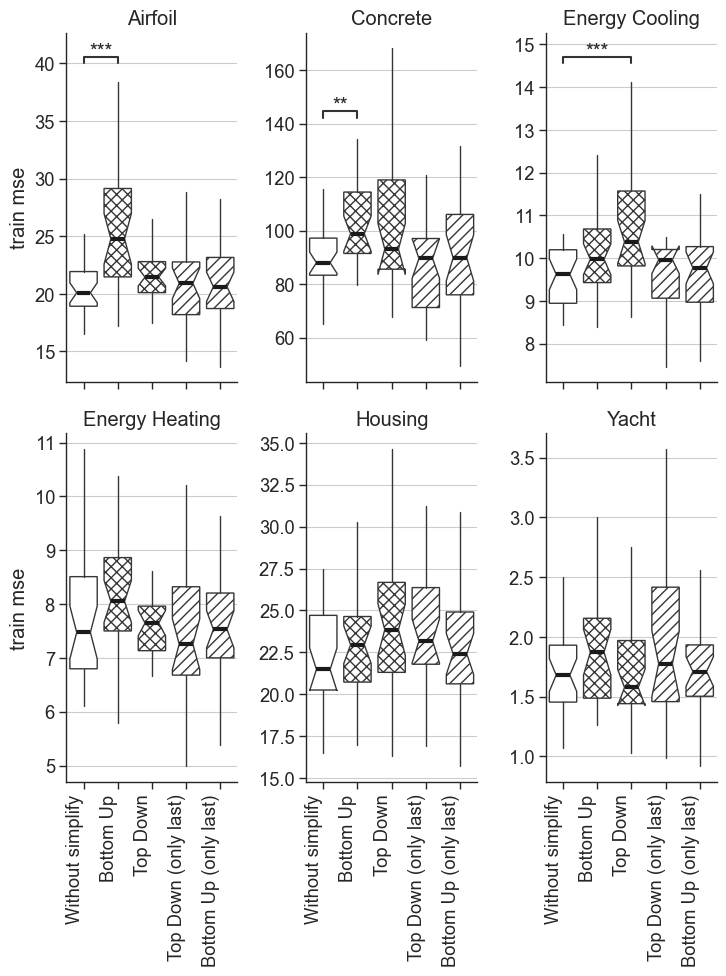

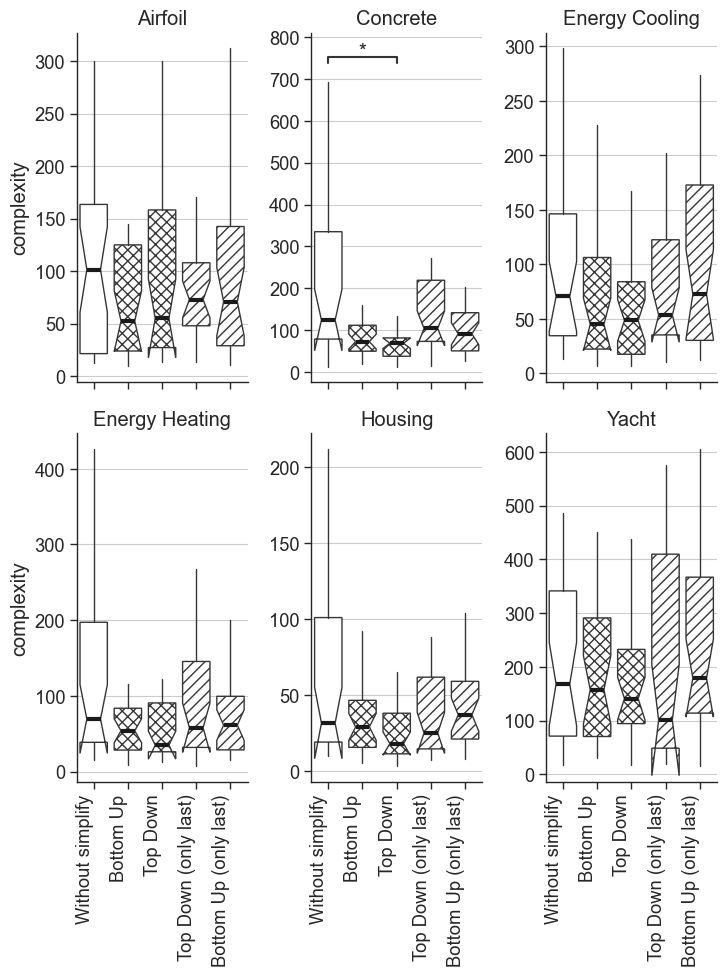

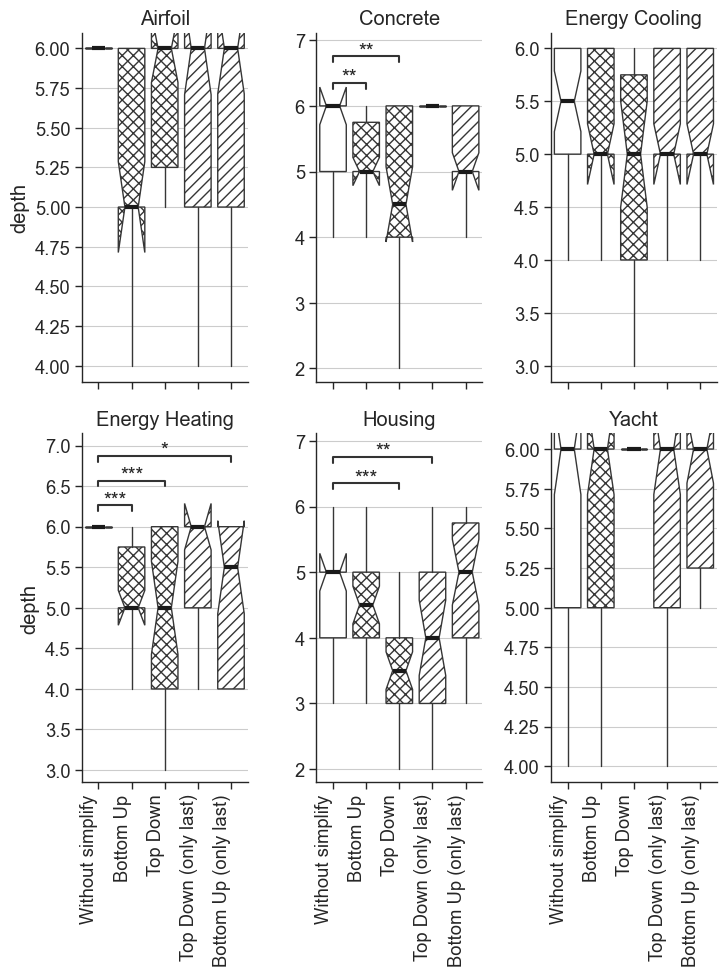

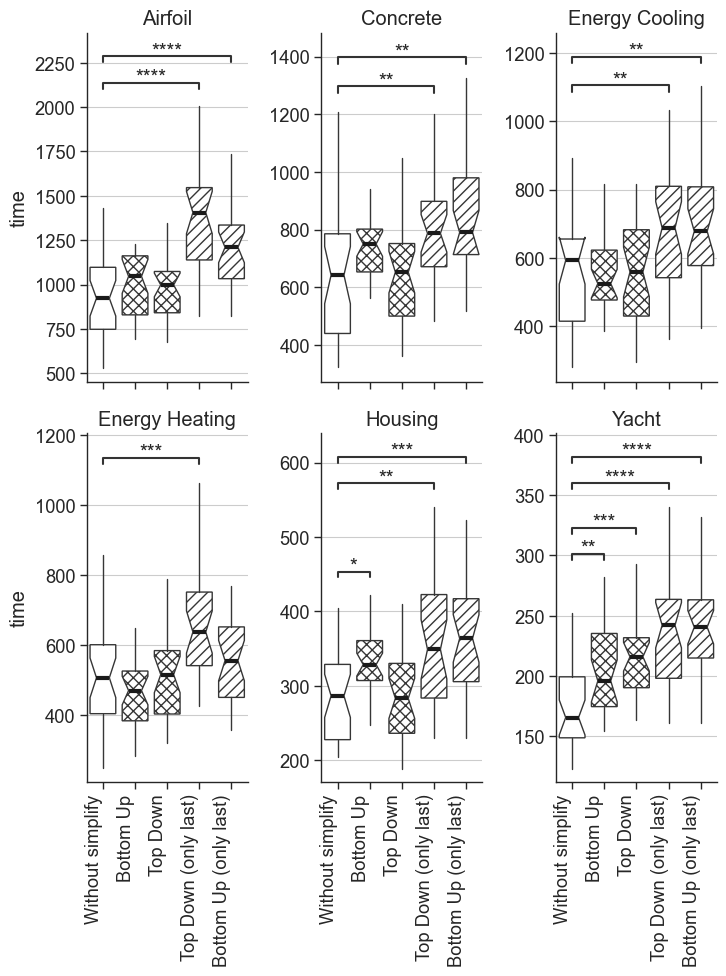

In [2]:
results_df['(only last)'] = results_df['model'].apply(lambda model: model.endswith("(only last)"))
  
for yaxis in ['size', 'test_mse', 'test_r2', 'train_mse', 'complexity', 'depth', 'time']:
    
    # Exploring boxplot results first
    g = sns.catplot(data=results_df, x='model', y=yaxis, hue='(only last)',
        col='dataset', col_wrap=col_wrap, order=order, 
        **boxplot_kwargs, sharey=False, legend_out=False, aspect=0.5)

    # g.map_dataframe(sns.swarmplot, x="model", y=yaxis, 
    #                 palette=["#000000"], size=3,
    #                 alpha=0.5, dodge=True)

    g.set_titles("{col_name}").set_axis_labels("", yaxis.replace("_", " "))

    for (ds, plot_ax) in g._axes_dict.items():
        plot_ax.grid(which='major', axis='y', linewidth=.8)
        
        for tick in plot_ax.get_xticklabels():
            tick.set(rotation=90, ha="right")

        # All vs baseline
        pairs = [('Without simplify', l)
                    for l in results_df[results_df['dataset']==ds]['model'].unique()
                    if l != 'Without simplify']

        # Contextual vs non-NSGA2
        # pairs = [
        #     ('Baseline', 'C-D-TS')
        # ]

        if True:
            try:
                annotator = Annotator(
                    plot_ax, pairs, data=results_df[(results_df['dataset']==ds)],
                    x='model', y=yaxis,
                    order=order)
                annotator.reset_configuration()
                annotator.configure(test="Mann-Whitney", hide_non_significant=True, #text_format='full',
                                    comparisons_correction="holm", verbose=0, text_offset=-3)
                
                # Calculate and annotate
                annotator.apply_and_annotate()
            except Exception as e:
                print(f"failed to add statsannotation with dataset {ds}. Except {e}")

    # Adding hatches -------------------------------------------------------------------
    # comment/uncomment block to add hatches. Make sure to unco
    # comment hue when generating the plot
        hatches = ['///', 'xxx']
        # select the correct patches
        patches = [patch for patch in plot_ax.patches if type(patch) == mpl.patches.PathPatch]
        # the number of patches should be evenly divisible by the number of hatches
        h = hatches * (len(patches) // len(hatches))

        # iterate through the patches for each subplot
        for patch, model in zip(patches, order):
            if model != 'Without simplify':
                patch.set_hatch(hatches[0 if model.endswith("(only last)") else 1])
            
    # Fixing the legend to add the hatches
    for lp, hatch in zip(g.legend.get_patches(), hatches):
        lp.set_hatch(hatch)
        lp.set_facecolor('none')
    # ----------------------------------------------------------------------------------
    #g.set(yscale="log")

    g._legend.remove()
    plt.tight_layout()
    plt.savefig(f"../paper/figs/{yaxis}_boxplot.pdf")
    plt.savefig(f"../paper/figs/{yaxis}_boxplot.png")
    plt.show()  
    
    if False:
        cd_df = results_df.copy()#.dropna() # (Just Island model sometimes gives an NAN)
        
        # Line below controls if we take the median or use each random seed as a different problem in CD
        # cd_df = cd_df.groupby(['model', 'dataset']).median().reset_index()
        
        cd_df = cd_df[cd_df.model.isin(model_nice)]
        cd_df['dataset_random_state'] = cd_df['dataset'] + '_' + cd_df['random_state'].astype(str)

        cd_df = cd_df[['model', 'dataset_random_state', yaxis]]
        display(cd_df.pivot('dataset_random_state', 'model').sample(3).style.background_gradient(cmap='viridis_r', axis=1))
        
        cd_df.columns = ['classifier_name', 'dataset_name', 'accuracy']
        # display(cd_df.sample())

        if yaxis != 'test_r2': # if smaller is better
            cd_df.accuracy = cd_df.accuracy*-1 

        # for ds in results_df['dataset'].unique():
        #     print(ds)
        #     draw_cd_diagram(cd_df[cd_df['dataset_name'].str.startswith(ds)],
        #                    alpha=0.05, path=f"../paper/figs/{yaxis}_criticaldifferences_{ds}.pdf")

        print("final critical differences diagram")
        draw_cd_diagram(cd_df, alpha=0.05, path=f"../paper/figs/{yaxis}_criticaldifferences.pdf")